In [64]:
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph,START,END
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from typing import TypedDict,Literal,Annotated
from IPython.display import Image,Markdown
from langchain.prompts import PromptTemplate

In [65]:
load_dotenv()
model=ChatOpenAI(model="gpt-4o-mini")

In [66]:
class ReviewStateSchema(TypedDict):
    review:str
    sentiment:Literal['positive','negative']
    diagnosis:dict
    response:str

In [67]:
class SentimentSchema(BaseModel):
    sentiment:Annotated[Literal['positive','negative'],Field(description="Sentiment of the review")]

sentiment_model=model.with_structured_output(SentimentSchema)

In [68]:
class DiagnosisSchema(BaseModel):
    issue_type:Annotated[Literal["UX","Performance","Bug","Support","Other"],Field(description="This is the class under which issue is classified")]
    tone:Annotated[Literal['angry','frustated','disappointed','calm'],Field(description="This is the tone of the person who is giving review.")]
    urgency:Annotated[Literal['low','medium','high'],Field(description="How urgent or critical the issue is?")]
diagnosis_model=model.with_structured_output(DiagnosisSchema)

In [69]:
def find_sentiment(state:ReviewStateSchema)->ReviewStateSchema:
    review=state['review']
    template=PromptTemplate(template="""
    You will be provided with a review you have to give a sentiment on that review as positive or negative.
    Review: {review}
""",input_variables=['review'])
    chain=template|sentiment_model
    review=chain.invoke(review)
    return {
        "sentiment":review.sentiment
    }

In [70]:
def conditional_flow(state:ReviewStateSchema)->Literal["run_diagnosis","response_positive"]:
    if state["sentiment"]=='positive':
        return "response_positive"
    else:
        return "run_diagnosis"

In [71]:
def run_diagnosis(state:ReviewStateSchema)->ReviewStateSchema:
    review=state['review']
    template=PromptTemplate(template="""
    You will be provied with the review of negative sentiment. You have to tell the class of issue that reviewer is facing, tone of reviewer and urgency of the issue to be resolved.
    Review: {review}
    """,
    input_variables=['review'])
    chain=template|diagnosis_model
    response=chain.invoke(review)
    return {
        "diagnosis":response.model_dump()
    }

In [72]:
def response_negative(state:ReviewStateSchema)->ReviewStateSchema:
    review=state['review']
    issue=state['diagnosis']['issue_type']
    tone=state['diagnosis']['tone']
    urgency=state['diagnosis']['urgency']


    prompt=PromptTemplate(template="""
        You have to act as a customer support agent. You will be given the review of customer and its issue, tone, and urgency of issue.
        You have to give appropriate response to that customer. 
        Review:{review}
        Issue:{issue}
        Tone:{tone}
        Urgency:{urgency}
    Do **not** include any name, job title, company name, or contact information in your response.
        """, input_variables=["review",'issue','tone','urgency'])
    chain=prompt|model
    response=chain.invoke({
        "review":review,
        "issue":issue,
        "tone":tone,
        "urgency":urgency
    })
    return {
        "response":response.content
    }

In [73]:
def response_positive(state:ReviewStateSchema)->ReviewStateSchema:
    review=state["review"]
    prompt=PromptTemplate(template="""
You are a customer support representative. A customer has left a positive review. Your job is to write a warm and professional response that:

- Thanks the customer
- Acknowledges what they liked
- Reinforces the positive experience
- Encourages them to return or recommend us
Do **not** include any name, job title, company name, or contact information in your response.
                          
Here is the review:
"{review}"
""", input_variables=['review'])
    chain=prompt|model
    response=chain.invoke({
        "review":review
    })
    return {
        "response":response.content
    }

In [74]:
graph=StateGraph(ReviewStateSchema)
graph.add_node("find_sentiment",find_sentiment)
graph.add_node("response_positive",response_positive)
graph.add_node("run_diagnosis",run_diagnosis)
graph.add_node("response_negative",response_negative)

graph.add_edge(START,"find_sentiment")
graph.add_conditional_edges("find_sentiment",conditional_flow)
graph.add_edge("run_diagnosis","response_negative")
graph.add_edge("response_negative",END)
graph.add_edge("response_positive",END)

In [75]:
workflow=graph.compile()

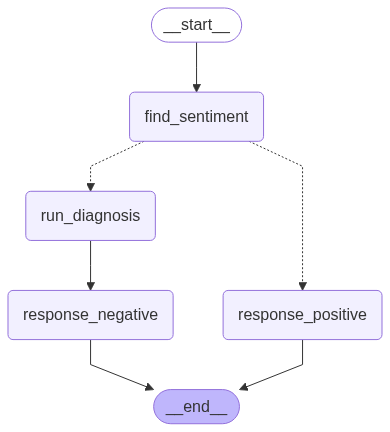

In [76]:
Image(workflow.get_graph().draw_mermaid_png())

In [77]:
positive_review="Absolutely love how easy the checkout process was and how quickly my order arrived. Fantastic service!"
response=workflow.invoke({
    'review':positive_review
})
Markdown(response['response'])

Thank you so much for your wonderful feedback! We're thrilled to hear that you found our checkout process easy and that your order arrived quickly. Providing a seamless experience is our top priority, and it’s great to know we met your expectations. We truly appreciate your support and hope to see you back soon. Feel free to recommend us to your friends and family!

In [78]:
negative_review="The app crashes every time I try to log in, and I haven't received any support for three days. This is really frustrating!"
response2=workflow.invoke({
    'review':negative_review
})
Markdown(response2['response'])

I completely understand how frustrating it must be to deal with constant app crashes while trying to log in, especially without any support for the past few days. We sincerely apologize for the inconvenience this has caused you. 

Please know that we are prioritizing this issue and will work to resolve it as quickly as possible. In the meantime, to help us troubleshoot the problem more effectively, could you please provide details about your device and the app version you are using? Your feedback is invaluable, and we're committed to getting this fixed for you promptly. Thank you for your patience!